# Visualizing Dirichlet on a Simplex (3 supports)

Based on
http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/

with extensions

## Making a mesh grid of n polygon

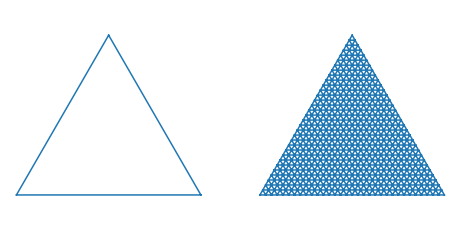

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri


def polygon_mesh(s=4, n=3, r=1):
    """
    Paramters:
        * s: subdivision depth
        * n: number of sides of the polygon
        * r: radius of the polygon, i.e. distance between 
             center of the polygon to one of the verticies
       
    Return:
        * vertices: vertices of the polygon
        * triangle: triangulated version of the polygon 
            (matplotlib.tri.triangulation.Triangulation)
        * trimesh: triangle mesh version of the polygon
            (matplotlib.tri.triangulation.Triangulation)
    """
    vertices = np.c_[r * np.cos(2 * np.pi * np.arange(1, n+1) / n  - (np.pi/2-np.pi/n)), 
                     r * np.sin(2 * np.pi * np.arange(1, n+1) / n  - (np.pi/2-np.pi/n))]
    if n>3: # add the center to triangulation
        vertices = np.vstack([vertices, vertices.mean(axis=0)])

    triangle = tri.Triangulation(vertices[:, 0], vertices[:, 1])
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=s if n>3 else s+1)
    
    return vertices, triangle, trimesh

vertices, triangle, trimesh = polygon_mesh(s=4, n=3, r=1)

plt.figure(figsize=(8, 4))
for (i, mesh) in enumerate((triangle, trimesh)):
    plt.subplot(1, 2, i+ 1)
    plt.triplot(mesh)
    plt.axis('off')
    plt.axis('equal')

## Converting to Barycenter coordinates

The barycentric coordinates $\Lambda = [\lambda_1, \lambda_2, \lambda_3]$ and the Cartesian coordinates $[X, Y]$ have the following relationships.

$$\begin{bmatrix} \lambda_1 & \lambda_2 & \lambda_3 \end{bmatrix} \cdot \begin{bmatrix} x_1 & y_1 & 1 \\x_2 & y_2 & 1 \\ x_3 & y_3 & 1\end{bmatrix} =\begin{bmatrix} \lambda_1  x_1 + \lambda_2 x_2 + \lambda_3 x_3\\
\lambda_1  y_1 + \lambda_2 y_2 + \lambda_3 y_3\\ \lambda_1 + \lambda_2 + \lambda_3 \end{bmatrix}^T
= \begin{bmatrix} X \\ Y \\ 1 \end{bmatrix}^T$$

where $[(x_1, y_1), (x_2, y_2), (x_3, y_3)]$ are the Cartesian vertices of the simplex.

In [2]:
def barycentric_coordinates_simplex(vertices, points):
    """
    Convert a set of Cartesian points into barycentric
    coordinates given the vertices of the simplex.
    
    Use the relationship:
                      [[x1, y1, 1],     
      [λ1, λ2, λ3] *   [x2, y2, 1],  = [X, Y, 1]
                       [x3, y3, 1]]
                       
    where 
    λ are Barycentric coorinates, 
    x1, y1, ... etc. are vertices, and 
    X, Y are Cartesian points
    
    This function can solve multi-dimensional simplex barycentric coordinates.
    """
    # Make the vertice matrix
    T = np.hstack([vertices, np.ones((3, 1))])
    if len(points.shape) < 2:
        points = points[np.newaxis, :]
    P = np.hstack([points, np.ones((points.shape[0], 1))])
    Lambdas = np.matmul(P, np.linalg.inv(T))
    if points.shape[0]<2:
        Lambdas = Lambdas[0]
    return Lambdas    


def barycentric_coordinates_simplex2(vertices, points):
    """
    Convert a set of Cartesian points into barycentric
    coordinates given the vertices of the simplex.
    
    Use the relationship:
                [[x1-x3, y1-y3],     
      [λ1, λ2] * [x2-x3, y2-y3]] = [X-x3, Y-y3]
                       
       λ3 = 1 - λ1 - λ2
                       
    where 
    λ are Barycentric coorinates, 
    x1, y1, ... etc. are vertices, and 
    X, Y are Cartesian points
    
    This function can solve multi-dimensional simplex barycentric coordinates.
    """
    T = vertices[:-1, :] - vertices[-1:None, :]
    if len(points.shape) < 2:
        points = points[np.newaxis, :]
    P = points - vertices[-1:None, :]
    Lambdas = np.matmul(P, np.linalg.inv(T))
    # Calculate the last lambda
    Lambdas = np.hstack([Lambdas, 1-np.sum(Lambdas, axis=1, keepdims=True)])
    if points.shape[0]<2:
        Lambdas = Lambdas[0]
    return Lambdas
    

In [3]:
points = np.array([0.1, 0.2])
print(barycentric_coordinates_simplex(vertices, points))
print(barycentric_coordinates_simplex2(vertices, points))

[0.46666667 0.20893164 0.32440169]
[0.46666667 0.20893164 0.32440169]


## Calculate Dirichlet PDF

In [4]:
from scipy.special import gamma as gamma_func
def dirichlet_pdf(alpha, x):
    """
    alpha: array of Dirichlet alpha parameter
    x: array of the support of Dirichlet
    """
    alpha , x = np.array(alpha), np.array(x)
    assert alpha.shape[0] == x.shape[-1]
    coef = gamma_func(np.sum(alpha)) / np.prod(gamma_func(alpha))
    pdf = coef * np.prod(np.power(x, alpha-1), axis=1 if len(x.shape)>1 else None)
    return pdf

dirichlet_pdf([0.3, 0.5, 0.3], [0.2,0.4,0.4])

0.5556159521906762

## Make the plots

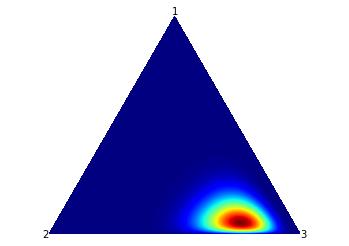

In [5]:
def plot_dirichlet_contour(alpha=np.array([1, 1, 1]), nlevels=200, resolution=8, cmap='jet', **kwargs):
    # Make the polygon
    vertices, _, trimesh = polygon_mesh(s=resolution, n=3, r=1)
    # Convert to Barycentric coordinates
    points = np.c_[trimesh.x, trimesh.y]
    shifts = np.min(vertices, axis=0)
    points = points - shifts
    vertices = vertices - shifts
    bary_coord = barycentric_coordinates_simplex(vertices, points)
    # Calculate Dirichlet pdf
    pvals = dirichlet_pdf(alpha, bary_coord)

    # Make the plot
    plt.tricontourf(trimesh, pvals, nlevels, cmap=cmap, **kwargs)
    plt.gca().text(vertices[0,0]+shifts[0], vertices[0, 1]+shifts[1], "1", ha='center', va='bottom')
    plt.gca().text(vertices[1,0]+shifts[0], vertices[1, 1]+shifts[1], "2", ha='right', va='center')
    plt.gca().text(vertices[2,0]+shifts[0], vertices[2, 1]+shifts[1], "3", ha='left', va='center')

    plt.axis('equal')
    plt.axis('off')
    
plot_dirichlet_contour([2, 5, 15])

# Barycentric Coordinates of Convex N polygon


## Wachpress Coordinates
[Generalized Barycentric Coordinates on Irregular Polygons](http://www.geometry.caltech.edu/pubs/MHBD02.pdf)

Which is a form of Wachpress coordinates (see [Generalized barycentric coordinates and applications](https://www.mn.uio.no/math/english/people/aca/michaelf/papers/gbc.pdf))

In [6]:
def cotangent(a, b, c):
    """
    Compute cotagent of non-degenerate triangle abc at vertex b
    Point a can be a m x 2 matrix
    """
    ba = a - b # m x 2 matrix
    bc = c - b # 1 x 2 vector
    return np.dot(ba, bc) / np.abs(np.cross(ba, bc)+1E-6) # 1 x m vector
    

def barycentric_coordinates_n_polygon(vertices, points):
    """
    Compute the barycentric weights for a set of points in an N polygon
    Assume all the points are strictly within the polygon 
    and the vertices are ordered. Uses Wachpress coordinates.
    
    Reference: Generalized Barycentric Coordinates on Irregular Polygons
    http://www.geometry.caltech.edu/pubs/MHBD02.pdf

    For a single point "p", the algorithm is:
    
    cotangent = lambda a, b, c: np.dot(c-b, a-b) / np.sum((np.cross(c-b, a-b))**2)
    
    n = vertices.shape[0] # number of sides / vertices in the polygon
    w = np.empty(n)
    for j, q_j in enumerate(vertices):
        prev_index = (j+n-1) % n
        next_index = (j+1) % n
        w[j] = (cotangent(p, q_j, vertices[prev_index]) + \
                cotangent(p, q_j, vertices[next_index])) / \
                np.sum((p - q_j)**2)
        
    w = w / np.sum(w)
    
    return w
    """
    if len(points.shape) < 2:
        points = points[np.newaxis, :]
    n = vertices.shape[0] # number of sides / vertices in the polygon
    m = points.shape[0] # number of points
    w = np.empty((m, n)) # m points, n vertices
    for j, q_j in enumerate(vertices):
        prev_index = (j+n-1) % n
        next_index = (j+1) % n
        w[:, j] = (cotangent(points, q_j, vertices[prev_index]) + \
                   cotangent(points, q_j, vertices[next_index])) / \
                   np.sum((points - q_j)**2+1E-6, axis=1)
        
    # Normalize weights
    w = w / np.sum(w, axis=1, keepdims=True)
    
    if w.shape[0] < 2:
        w = w[0]
    
    return w

vertices, _, trimesh = polygon_mesh(s=4, n=3, r=1)
points = np.array([[0.3, 0.2], [0.1, 0.2]])
print(barycentric_coordinates_simplex(vertices, points))
print(barycentric_coordinates_n_polygon(vertices, points))

[[0.46666667 0.09346159 0.43987175]
 [0.46666667 0.20893164 0.32440169]]
[[0.46666494 0.09346172 0.43987335]
 [0.466666   0.20893176 0.32440224]]


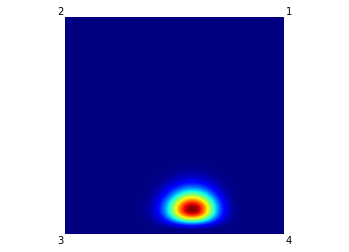

In [7]:
def plot_dirichlet_contour_n_poly(alpha=np.array([1, 1, 1]), nlevels=200, resolution=8, cmap='jet', **kwargs):
    # Make the polygon
    vertices, _, trimesh = polygon_mesh(s=resolution, n=len(alpha), r=1)
    if vertices.shape[0]>3: # for polygons greater than 3
        center, vertices = vertices[-1, :], vertices[:-1, :]
    else:
        center = np.mean(vertices, axis=0)
    # Convert to Barycentric coordinates
    points = np.c_[trimesh.x, trimesh.y]
    shifts = np.min(vertices, axis=0)
    points = points - shifts
    offsets = (vertices - center) * 0.05
    vertices = vertices - shifts
    bary_coord = barycentric_coordinates_n_polygon(vertices, points)
    #bary_coord[~np.isfinite(bary_coord)] = 0
    # Calculate Dirichlet pdf
    pvals = dirichlet_pdf(alpha, bary_coord)

    # Make the plot
    plt.tricontourf(trimesh, pvals, nlevels, cmap=cmap, **kwargs)
    
    # Label the vertices
    for i in range(vertices.shape[0]):
        plt.gca().text(vertices[i,0]+shifts[0]+offsets[i, 0], vertices[i, 1]+shifts[1]+offsets[i, 1], 
                       "{:d}".format(i+1), ha='center', va='center')
    
    plt.axis('equal')
    plt.axis('off')

alpha = np.array([2, 5, 15, 25])
plot_dirichlet_contour_n_poly(alpha)

## Global form of Wachpress Coordinates

Notice the results are closer to that of Simplex form

In [98]:
def calculate_area(a, b, c):
    """
    Calculate area of a triangle given the 3 vertices
    Points a,b,c can be either m x 2 matrix or 1 x 2 vectors
    """
    ba = a - b # m x 2
    bc = c - b # 1 x 2
    # ignore that constant 1/2, 
    # as it would be normalized out anyway
    return np.cross(bc, ba) 
    
def barycentric_coordinates_n_polygon_global(vertices, points):
    """
    Compute the barycentric weights for a set of points in an N polygon
    Assume all the points are strictly within the polygon 
    and the vertices are ordered. Uses Wachpress Coordinates Global Form, 
    where the coordinates is valid on the edge. Although it is
    more general, the form would require larger calculation when N is large.
    
    Reference: Generalized barycentric coordinates and applications
    https://www.mn.uio.no/math/english/people/aca/michaelf/papers/gbc.pdf
    """
    if len(points.shape) < 2:
        points = points[np.newaxis, :]
    n = vertices.shape[0] # number of sides / vertices in the polygon
    m = points.shape[0] # number of points
    w = np.empty((m, n)) # m points, n vertices
    vertices_prev = np.concatenate([vertices[-1:None, :], vertices[:-1, :]], axis=0)
    vertices_next = np.concatenate([vertices[1:, :], vertices[0:1, :]], axis=0)
    # area of x, v_i, v_i+1
    A = np.array([list(calculate_area(points, vertices[i], vertices_next[i])) for i in range(n)]).T
    # area of v_i-1, v_i, v_i+1
    C = calculate_area(vertices_prev, vertices, vertices_next)
    for j, q_j in enumerate(vertices):
        prev_index = (j+n-1) % n
        next_index = (j+1) % n
        w[:, j] = C[j] * np.prod(A[:, np.setdiff1d(np.arange(n), [prev_index, j])], axis=1)
        
    # Normalize weights
    w = w / np.sum(w, axis=1, keepdims=True)
    
    if w.shape[0] < 2:
        w = w[0]
    
    return w

vertices, _, trimesh = polygon_mesh(s=4, n=3, r=1)
points = np.array([[0.3, 0.2], [0.1, 0.2], [0.3, 0.2], [0.1, 0.1], [0.2, 0.2], [-0.2, -0.3]])
print(barycentric_coordinates_simplex(vertices, points))
print(barycentric_coordinates_n_polygon(vertices, points))
print(barycentric_coordinates_n_polygon_global(vertices, points))

[[0.46666667 0.09346159 0.43987175]
 [0.46666667 0.20893164 0.32440169]
 [0.46666667 0.09346159 0.43987175]
 [0.4        0.24226497 0.35773503]
 [0.46666667 0.15119661 0.38213672]
 [0.13333333 0.54880339 0.31786328]]
[[0.46666494 0.09346172 0.43987335]
 [0.466666   0.20893176 0.32440224]
 [0.46666494 0.09346172 0.43987335]
 [0.39999963 0.24226508 0.35773529]
 [0.46666565 0.15119677 0.38213758]
 [0.1333336  0.54880359 0.31786281]]
[[0.46666667 0.09346159 0.43987175]
 [0.46666667 0.20893164 0.32440169]
 [0.46666667 0.09346159 0.43987175]
 [0.4        0.24226497 0.35773503]
 [0.46666667 0.15119661 0.38213672]
 [0.13333333 0.54880339 0.31786328]]


# Barycentric Coordinates of Arbitrary Polygon


## Mean Value Coordinates
Use Mean Value Coordinates (see [Generalized barycentric coordinates and applications](https://www.mn.uio.no/math/english/people/aca/michaelf/papers/gbc.pdf)), which applies to any arbitrary polygons, including star shaped.

In [71]:
def tangenthalf(a, b, c):
    """
    Compute tan(α/2) of non-degenerate triangle abc at vertex b
    Using the relation tan(α/2) = (1-cos(α)) / sin(α)
    Point b can be a m x 2 matrix
    """
    ba = a - b # m x 2 
    bc = c - b # m x 2
    denom = np.sqrt(np.sum(ba**2, axis=1) * np.sum(bc**2, axis=1) ) # m x 1
    cosalpha  = np.einsum('ij,ij->i', ba, bc) 
    sinalpha  = np.cross(bc, ba) + 1E-6
    return (denom - cosalpha) / sinalpha
    

def barycentric_coordinates_arbitrary_n_polygon(vertices, points):
    """
    Compute the barycentric weights for a set of points in an N polygon
    Assume all the points are strictly within the polygon 
    and the vertices are ordered
    
    Reference: Generalized barycentric coordinates and applications
    https://www.mn.uio.no/math/english/people/aca/michaelf/papers/gbc.pdf    
    """
    if len(points.shape) < 2:
        points = points[np.newaxis, :]
    n = vertices.shape[0] # number of sides / vertices in the polygon
    m = points.shape[0] # number of points
    w = np.empty((m, n)) # m points, n vertices
    for i, v_i in enumerate(vertices):
        prev_index = (i+n-1) % n
        next_index = (i+1) % n
        w[:, i] = (tangenthalf(vertices[prev_index], points, v_i) \
                  + tangenthalf(v_i, points, vertices[next_index])) \
                  / np.sqrt(np.sum((points - v_i)**2+1E-6, axis=1))
        
    # Normalize weights
    w = w / np.sum(w, axis=1, keepdims=True)
    
    if w.shape[0] < 2:
        w = w[0]
    
    return w

vertices, _, trimesh = polygon_mesh(s=4, n=3, r=1)
points = np.array([[0.3, 0.2], [0.1, 0.2]])
print(barycentric_coordinates_simplex(vertices, points))
print(barycentric_coordinates_n_polygon(vertices, points))
print(barycentric_coordinates_arbitrary_n_polygon(vertices, points))

[[0.46666667 0.09346159 0.43987175]
 [0.46666667 0.20893164 0.32440169]]
[[0.46666494 0.09346172 0.43987335]
 [0.466666   0.20893176 0.32440224]]
[[0.46666672 0.09346142 0.43987186]
 [0.46666656 0.20893165 0.32440179]]


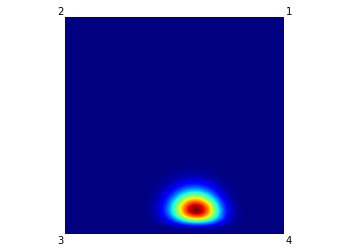

In [72]:
def plot_dirichlet_contour_arbitrary_n_poly(alpha=np.array([1, 1, 1]), nlevels=200, resolution=8, cmap='jet', **kwargs):
    # Make the polygon
    vertices, _, trimesh = polygon_mesh(s=resolution, n=len(alpha), r=1)
    if vertices.shape[0]>3: # for polygons greater than 3
        center, vertices = vertices[-1, :], vertices[:-1, :]
    else:
        center = np.mean(vertices, axis=0)
    # Convert to Barycentric coordinates
    points = np.c_[trimesh.x, trimesh.y]
    shifts = np.min(vertices, axis=0)
    points = points - shifts
    offsets = (vertices - center) * 0.05
    vertices = vertices - shifts
    bary_coord = barycentric_coordinates_arbitrary_n_polygon(vertices, points)
    #bary_coord[~np.isfinite(bary_coord)] = 0
    # Calculate Dirichlet pdf
    pvals = dirichlet_pdf(alpha, bary_coord)

    # Make the plot
    plt.tricontourf(trimesh, pvals, nlevels, cmap=cmap, **kwargs)
    
    # Label the vertices
    for i in range(vertices.shape[0]):
        plt.gca().text(vertices[i,0]+shifts[0]+offsets[i, 0], vertices[i, 1]+shifts[1]+offsets[i, 1], 
                       "{:d}".format(i+1), ha='center', va='center')
    
    plt.axis('equal')
    plt.axis('off')

alpha = np.array([2, 5, 15, 25])
plot_dirichlet_contour_arbitrary_n_poly(alpha)

## Global form of Mean Value Coordinates

Notice the results are closer to that of Simplex form

In [78]:
def barycentric_coordinates_arbitrary_n_polygon_global(vertices, points):
    """
    Compute the barycentric weights for a set of points in an N polygon
    Assume all the points are strictly within the polygon 
    and the vertices are ordered. Uses Mean Value Coordinates Global Form,
    where the coordinates is valid on the edge. Although it is
    more general, the form would require larger calculation when N is large.
    
    Reference: Generalized barycentric coordinates and applications
    https://www.mn.uio.no/math/english/people/aca/michaelf/papers/gbc.pdf    
    """
    if len(points.shape) < 2:
        points = points[np.newaxis, :]
    n = vertices.shape[0] # number of sides / vertices in the polygon
    m = points.shape[0] # number of points
    w = np.empty((m, n)) # m points, n vertices
    d = vertices.T[np.newaxis, :, :] - points[:, :, np.newaxis] # points(m) x xy_coords(2) x vertices(n)
    r = np.sqrt(d[:, 0, :]**2 + d[:, 1, :]**2) # points (m) x vertices (n)
    # points (m) x vertices (n) 
    r_d_vec = r * np.concatenate([r[:, 1:], r[:, 0:1]], axis=1) \
                + np.sum(d * np.concatenate([d[:, :, 1:], d[:, :, 0:1]], axis=2), axis=1)
    for i in range(n):
        prev_index = (i+n-1) % n
        next_index = (i+1) % n
        w[:, i] = (r[:, prev_index] * r[:, next_index] \
                                    - np.einsum('ij,ij->i', d[:, :, prev_index], d[:, :, next_index])) \
                   * np.prod(r_d_vec[:, np.setdiff1d(np.arange(n), [prev_index, i])], axis=1)
        
    # Normalize weights
    w = np.sqrt(w)
    w = w / np.sum(w, axis=1, keepdims=True)
    
    if w.shape[0] < 2:
        w = w[0]
    
    return w

vertices, _, trimesh = polygon_mesh(s=4, n=3, r=1)
points = np.array([[0.3, 0.2], [0.1, 0.2], [0.3, 0.2], [0.1, 0.1], [0.2, 0.2], [-0.2, -0.3]])
print(barycentric_coordinates_simplex(vertices, points))
print(barycentric_coordinates_n_polygon(vertices, points))
print(barycentric_coordinates_arbitrary_n_polygon_global(vertices, points))

[[0.46666667 0.09346159 0.43987175]
 [0.46666667 0.20893164 0.32440169]
 [0.46666667 0.09346159 0.43987175]
 [0.4        0.24226497 0.35773503]
 [0.46666667 0.15119661 0.38213672]
 [0.13333333 0.54880339 0.31786328]]
[[0.46666494 0.09346172 0.43987335]
 [0.466666   0.20893176 0.32440224]
 [0.46666494 0.09346172 0.43987335]
 [0.39999963 0.24226508 0.35773529]
 [0.46666565 0.15119677 0.38213758]
 [0.1333336  0.54880359 0.31786281]]
[[0.46666667 0.09346159 0.43987175]
 [0.46666667 0.20893164 0.32440169]
 [0.46666667 0.09346159 0.43987175]
 [0.4        0.24226497 0.35773503]
 [0.46666667 0.15119661 0.38213672]
 [0.13333333 0.54880339 0.31786328]]


# Visualizing a high dimensional probability distribution on a polygon

In the previous sections, we visualized Dirichlet distribution by converting Cartesian coordinates into barycentric coordinates (i.e. the supports of categorical / multinomial distribution), and calculated the corresponding PDF of the supports. The goal in this section is reversed, where we are given the supports of the categorical / multinomial distribution (i.e. barycentric coordinates), we want to convert back to Cartesian coordinates to be visualized on the given polygon. This is again using the relationship between Barycentric and Cartesian coordinates defined above, i.e.

$$\Lambda \cdot V = \begin{bmatrix} \lambda_1 & \lambda_2 & \lambda_3 & ...\end{bmatrix} \cdot \begin{bmatrix} x_1 & y_1 \\x_2 & y_2 \\ x_3 & y_3 \\ \vdots  & \vdots \end{bmatrix} = \begin{bmatrix} X & Y \end{bmatrix}$$

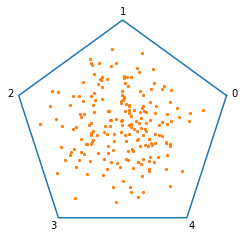

In [240]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def proba2cartesian(proba, r=1.0):
    """
    Convert a multinomial probability distributions into a 2D Cartesian coordinate
    
    Parameters:
    --------
    * proba: np.ndarray
        n x k matrix of probability distributions, whose row must sum to 1.
    * r : float, optional.
        Radius of the regular polygon. The default is 1.0.
    Returns:
    --------
    * points: np.ndarray
        n x 2 Cartesian coordinates (x, y) corresponding to each probability distribution
    * vertices: np.ndarray
        k x 2 Cartesian coordinates of the vertices of regular polygon.
    
    """
    proba = np.atleast_2d(proba)
    # Get the vertices of the regular polygon
    n = proba.shape[1]
    vertices = np.c_[r * np.cos(2 * np.pi * np.arange(1, n+1) / n  - (np.pi / 2 - np.pi / n)), 
                     r * np.sin(2 * np.pi * np.arange(1, n+1) / n  - (np.pi / 2 - np.pi / n))]
    # Convert probabilities (as Barycentric) into Cartesian
    points = proba @ vertices
    
    return points, vertices

def plot_proba(points, vertices, ax=None, label_offset=1.08, show_label=True):
    """Plot the probabilities on the polygon."""
    # Make the plot
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    # Plot the scatter of the probability distributions
    ax.scatter(points[:, 0], points[:, 1], s=5, color="#ff7f0e")

    # Plot the polygon
    polygon = np.r_[vertices, vertices[0:1, :]]
    ax.plot(polygon[:, 0], polygon[:, 1], color="#1f77b4")

    # Make labels on the vertices
    if show_label:
        labels = label_offset * vertices
        for i in range(vertices.shape[0]):
            ax.text(labels[i, 0], labels[i, 1], f"{i:d}", va="center", ha="center")
        ax.set_aspect("equal")
        ax.axis("off")
    return ax
    
# Make the plot
rs = np.random.RandomState(42)
proba = rs.dirichlet(np.ones(5)*1, size=200)
points, vertices = proba2cartesian(proba, r=4)
_ = plot_proba(points, vertices)



## Compare distance on the polyon vs. JS Entropy

In [236]:
def js_entropy(p, q):
    return np.sum(p * np.log(p / q)) * 0.5 + np.sum(q * np.log(q / p)) * 0.5

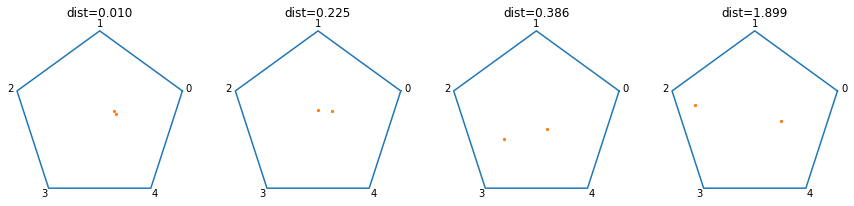

In [237]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
proba = [[] for _ in range(4)]

proba[0] = np.array([[0.31511728, 0.12045012, 0.28412796, 0.02563582, 0.25466883],
                     [0.33, 0.11, 0.26, 0.05, 0.25]])
proba[1] = np.array([[0.31511728, 0.12045012, 0.28412796, 0.02563582, 0.25466883],
                     [0.08457062, 0.26072954, 0.29498721, 0.01254854, 0.34716409]])
proba[2] = np.array([[0.14014644, 0.04935974, 0.28274635, 0.46219604, 0.06555144],
                     [0.22095176, 0.14958564, 0.14118523, 0.205537  , 0.28274036]])
proba[3] = np.array([[0.05317645, 0.02748941, 0.75386234, 0.09827935, 0.06719246],
                     [0.08040661, 0.35082735, 0.03987221, 0.04513501, 0.48375882]])
for i in range(len(proba)):
    ax = axs[i]
    points, vertices = proba2cartesian(proba[i], r=1)
    plot_proba(points, vertices, ax=ax)
    dist = js_entropy(proba[i][0, :], proba[i][1, :])
    ax.set_title(f"dist={dist:.3f}")
